# MUSIC Super-resolution Microscopy

## Dependencies

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

## Program Parameters

In [150]:
class params:
    k     = 2       # Source number
    M     = 16      # Sensor array size (assuming square)
    T     = 200     # Snapshot number
    noise = 0.00    # Noise power
    width = 1       # Sensors are placed between [-width,width]
    sep   = 0.25    # Source inter-separation distance
    sig   = 0.1     # Gaussian kernel variance
    Q     = 32      # MUSIC 'Resolution'
p = params()

## Create Source Locations

### (a) From True Source Points

In [193]:
# Evenly spaced sources
#w = np.linspace(-p.width/8,p.width/8,p.k)
w = np.linspace(-p.sep,p.sep,p.k)
w = np.vstack((w,w))

### (b) From Ground Truth Image

2


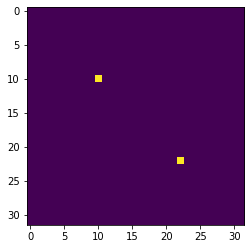

In [195]:
#truth = np.load("truth2.npy") 
truth = np.zeros((p.Q,p.Q))
truth[p.Q - p.Q//3, p.Q - p.Q//3] = 1
truth[p.Q//3,p.Q//3] = 1

# Get high-resolution grid size from image (assume square)
p.Q = truth.shape[0]

# Get high-resolution axis positions
v2 = np.linspace(-p.width,p.width,p.Q);

# Find non-zero entries in the truth, map to true locations
w = np.asarray(np.nonzero(truth))
w = v2[w]

# Get number of sources
p.k = w.shape[1]
print(p.k)

plt.figure()
plt.imshow(truth)
plt.show()

## Generation of U Matrix

In [152]:
# Uniform Linear Array (ULA)
v1 = np.arange(0,p.M).reshape(-p.width,p.width) - (p.M-1)//2
# Normalize between -1 and 1
v1 = 2*v1/p.M

# Build the Gaussian (U matrix)

U = np.zeros((p.M**2,p.k))
for k in range(p.k):
    argx = v1 - w[0,k]
    argy = v1 - w[1,k]
    
    vx = np.exp(-(0.5/p.sig**2)*np.square(argx))
    vy = np.exp(-(0.5/p.sig**2)*np.square(argy))

    V = vx @ vy.T
    U[:,k] = V.reshape(-1)

## Measurement Data Generation 

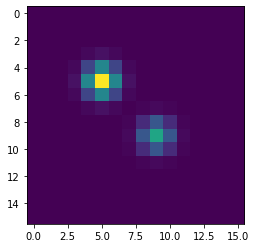

In [196]:
# Random Data
x = np.random.uniform(0,2,size=(p.k,p.T))
# Additive Gaussian Noise
n = p.noise * np.random.randn(p.M**2,p.T)
# Measurements
f = U @ x + n

plt.figure()
plt.imshow(np.abs(f[:,p.T//4]).reshape(p.M,p.M))
plt.show()

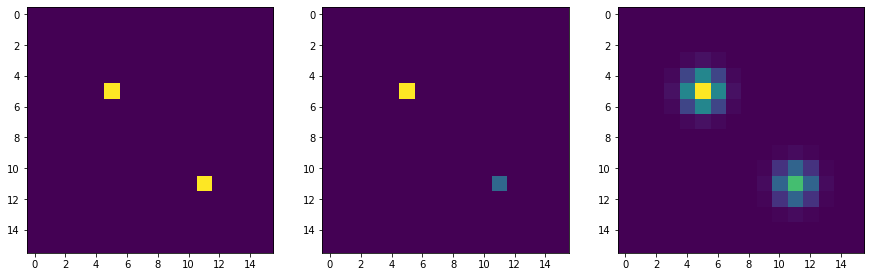

In [197]:
# Do Ux through 2D filter and decimation
x = np.repeat(truth[::p.Q//p.M,::p.Q//p.M][:,:,np.newaxis],p.T,axis=2)
nz = np.nonzero(x)
for ix,iy,iz in zip(*nz):
    x[ix,iy,iz] = np.random.uniform(0,2)
Ux = gaussian_filter(x, p.sig*p.M/2) 
Ux = Ux.reshape(p.M**2,p.T)

n = p.noise * np.random.randn(p.M**2,p.T)

f = Ux + n

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(truth[::p.Q//p.M,::p.Q//p.M])
plt.subplot(1,3,2)
plt.imshow(x[...,1])
plt.subplot(1,3,3)
plt.imshow(f[...,1].reshape(p.M,p.M))
plt.show()

## Perform MUSIC

In [200]:
def MUSIC2D(f, v1, L, sig, Q, width):
    # SVD Decomposition on our autocorrelation matrix
    U,_,_ = np.linalg.svd(f)
    # Sort singular values if not already sorted
    
    # Segment in to signal and noise subspaces
    #V1 = U[:,:L]
    U2 = U[:,:-L]
    
    # Build MUSIC high-resolution source 'grid'
    v2 = np.linspace(-width,width,Q)
    
    A = np.zeros((len(v1)**2,Q**2))
    q = 0
    for kx in v2:
        for ky in v2:
            argx = v1 - kx
            argy = v1 - ky
            
            ax = np.exp(-(0.5/p.sig**2)*np.square(argx))
            ay = np.exp(-(0.5/p.sig**2)*np.square(argy))
            a  = ax @ ay.T
            A[:,q] = a.reshape(-1)
            q = q + 1
    
    img = np.zeros((Q**2,1))
    for i in range(Q**2):
        #err = A[:,q].conj().T @ ( V2 @ V2.conj().T ) @ A[:,q]
        err =  np.linalg.norm(A[:,i])**2 - np.linalg.norm(U2@U2.T.conj()@A[:,i])**2
        print(err)
        img[i] = 1/err
    
    plt.plot(np.abs(img))
    return img.reshape(Q,Q)

6.938893903907228e-18
8.326672684688674e-17
0.0
1.1102230246251565e-16
3.3306690738754696e-16
3.885780586188048e-16
3.885780586188048e-16
1.1102230246251565e-16
-1.1102230246251565e-16
-6.106226635438361e-16
-7.216449660063518e-16
-6.106226635438361e-16
-1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16
0.0
2.220446049250313e-16
2.220446049250313e-16
4.996003610813204e-16
7.216449660063518e-16
6.106226635438361e-16
0.0
-3.885780586188048e-16
-4.996003610813204e-16
-3.885780586188048e-16
-1.1102230246251565e-16
-2.7755575615628914e-16
0.0
1.1102230246251565e-16
-1.1102230246251565e-16
-3.885780586188048e-16
-2.220446049250313e-16
2.7755575615628914e-17
2.220446049250313e-16
4.440892098500626e-16
4.440892098500626e-16
1.3322676295501878e-15
1.7763568394002505e-15
1.3322676295501878e-15
8.881784197001252e-16
-4.440892098500626e-16
-1.7763568394002505e-15
-2.220446049250313e-15
-1.9984014443252818e-15
-4.440892098500626e-16
8.881784197001252e-16
4.440892098500626e-16
0.0

<ipython-input-200-d2a758f2902a>:31: RuntimeWarning: divide by zero encountered in double_scalars
  img[i] = 1/err



4.440892098500626e-16
1.3322676295501878e-15
8.881784197001252e-16
8.881784197001252e-16
8.881784197001252e-16
8.881784197001252e-16
0.0
1.3322676295501878e-15
2.220446049250313e-15
3.1086244689504383e-15
1.7763568394002505e-15
1.3322676295501878e-15
-4.440892098500626e-16
0.0
0.0
-2.7755575615628914e-16
-8.881784197001252e-16
-1.1102230246251565e-15
-4.440892098500626e-16
-1.3322676295501878e-15
-8.881784197001252e-16
0.0
8.881784197001252e-16
2.6645352591003757e-15
2.220446049250313e-15
1.3322676295501878e-15
1.3322676295501878e-15
4.440892098500626e-16
8.881784197001252e-16
0.0
2.220446049250313e-15
1.7763568394002505e-15
1.7763568394002505e-15
1.3322676295501878e-15
1.7763568394002505e-15
1.3322676295501878e-15
8.881784197001252e-16
0.0
4.440892098500626e-16
1.3322676295501878e-15
1.3322676295501878e-15
8.881784197001252e-16
0.0
0.0
-4.440892098500626e-16
0.0
-6.661338147750939e-16
-2.220446049250313e-16
-4.440892098500626e-16
-6.661338147750939e-16
0.0
0.0
-8.881784197001252e-16


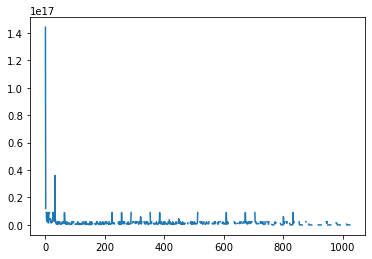

In [201]:
img = np.abs(MUSIC2D(f,v1,p.k,p.sig,p.Q,p.width))

## Results

### Create Ground Truth Image (if no ground truth loaded)

In [175]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx, a.flat[idx]

hr_axis = np.linspace(-1,1,p.Q)

# grab cords
wx = w[0,:]
wy = w[1,:]

# Find points on high-resolution grid closest to truth
truth = np.zeros((p.Q,p.Q))
for k in range(p.k):
    indx,_ = find_nearest(hr_axis,wx[k])
    indy,_ = find_nearest(hr_axis,wy[k])
    truth[indx,indy] = 1

### Create Diffraction Limited Image

In [176]:
dif_lim = np.mean(np.abs(f),axis=1).reshape(p.M,p.M)

### Create Plots

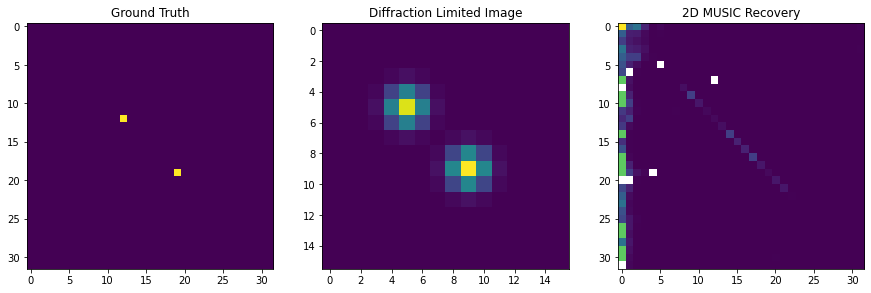

In [183]:
plt.figure(figsize=(15,10))
plt1 = plt.subplot(1,3,1)
plt.imshow(truth)
plt.title("Ground Truth")

plt2 = plt.subplot(1,3,2)
plt.imshow(dif_lim)
plt.title("Diffraction Limited Image")

plt3 = plt.subplot(1,3,3)
plt.imshow(img)
plt.title("2D MUSIC Recovery")

plt.show()